<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss,
                             precision_recall_fscore_support, classification_report, 
                             accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [4]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<h2>PRE-ELABORAZIONE DEL TESTO</h2>

In [5]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [6]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:34<00:00, 35.05it/s]


In [7]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [8]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [9]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

# Cerchiamo nuovamente righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]


,ID,Gene,Variation,Class,text


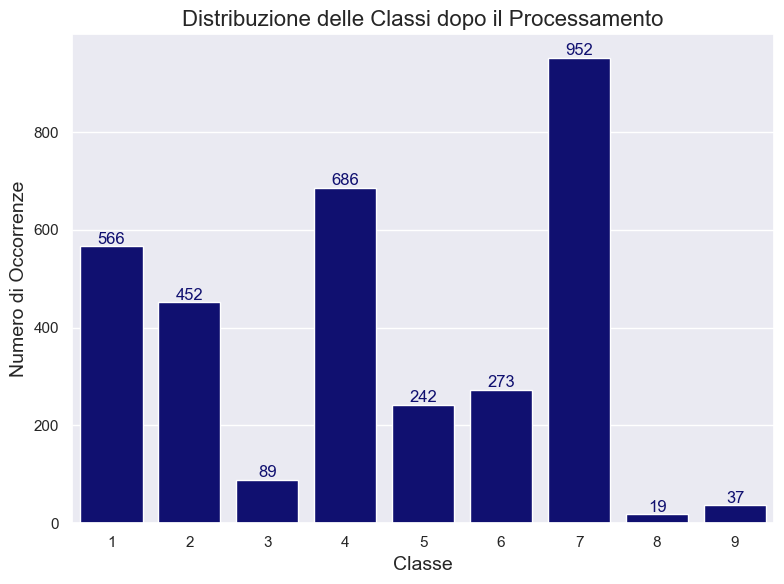

In [10]:
# Impostazioni estetiche per il grafico
sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

# Creazione del grafico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, color='navy')  # Imposta un colore uniforme per le barre

# Titolo e etichette
plt.title('Distribuzione delle Classi dopo il Processamento', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Occorrenze', fontsize=14)

# Aggiungere il numero sopra ogni barra con lo stesso colore della barra
for p in ax.patches:
    height = int(p.get_height())  # Otteniamo l'altezza della barra
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, 
                color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                xytext=(0, 5), textcoords='offset points')

# Mostra il grafico
plt.tight_layout()  # Ottimizza la disposizione per evitare sovrapposizioni
plt.show()


<h2> MODELLAZIONE</h2>

In [11]:
# Separazione delle feature e del target
X = df['text']
y = df['Class']

# Funzione per ottenere i modelli
def get_models():
    models = {
        "RF": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "LR": LogisticRegression(),
        "XGBoost": XGBClassifier()
    }
    return models

In [12]:
# Definizione delle griglie di parametri per i modelli
def get_param_grids():
    param_grids = {
        "RF": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20, 30, None],
        },
        
        "KNN": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance'],
        },
        
        "LR": {},
        
        "XGBoost": {
            "learning_rate": [0.1], 
            "n_estimators": [50, 100, 150],
            "max_depth": [3, 6, 9],
        }
    }
    return param_grids


In [13]:
# Funzione GridSearch con Cross Validazione
def perform_grid_search(model, X_train, y_train, param_grid):
    # GridSearch con Cross-Validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=0)
    
    # Fitting del modello
    grid_search.fit(X_train, y_train)
    
    # Migliori parametri trovati
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_model, best_params


In [14]:
# Funzione per valutare il modello
def evaluate_model(model, X_test, y_test):
    # Predizioni
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, recall, f1, accuracy


In [15]:
def plot_class_distribution(y_train, y_test, title_train="Distribuzione classi Train", title_test="Distribuzione classi Test"):
    # Conta le frequenze delle classi
    train_dist = np.unique(y_train, return_counts=True)
    test_dist = np.unique(y_test, return_counts=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Grafico per il dataset di training
    bars_train = axes[0].bar(train_dist[0], train_dist[1], color='blue', alpha=0.7)
    axes[0].set_title(title_train, loc='center', pad=20)
    axes[0].set_xlabel('Classi')
    axes[0].set_ylabel('Frequenza')

    # Aggiungi i valori sopra le barre
    for bar in bars_train:
        yval = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)
    
    # Grafico per il dataset di test
    bars_test = axes[1].bar(test_dist[0], test_dist[1], color='green', alpha=0.7)
    axes[1].set_title(title_test, loc='center', pad=20)
    axes[1].set_xlabel('Classi')
    axes[1].set_ylabel('Frequenza')

    # Aggiungi i valori sopra le barre
    for bar in bars_test:
        yval = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)

    # Ottimizza il layout e mostra i grafici
    plt.tight_layout()
    plt.show()

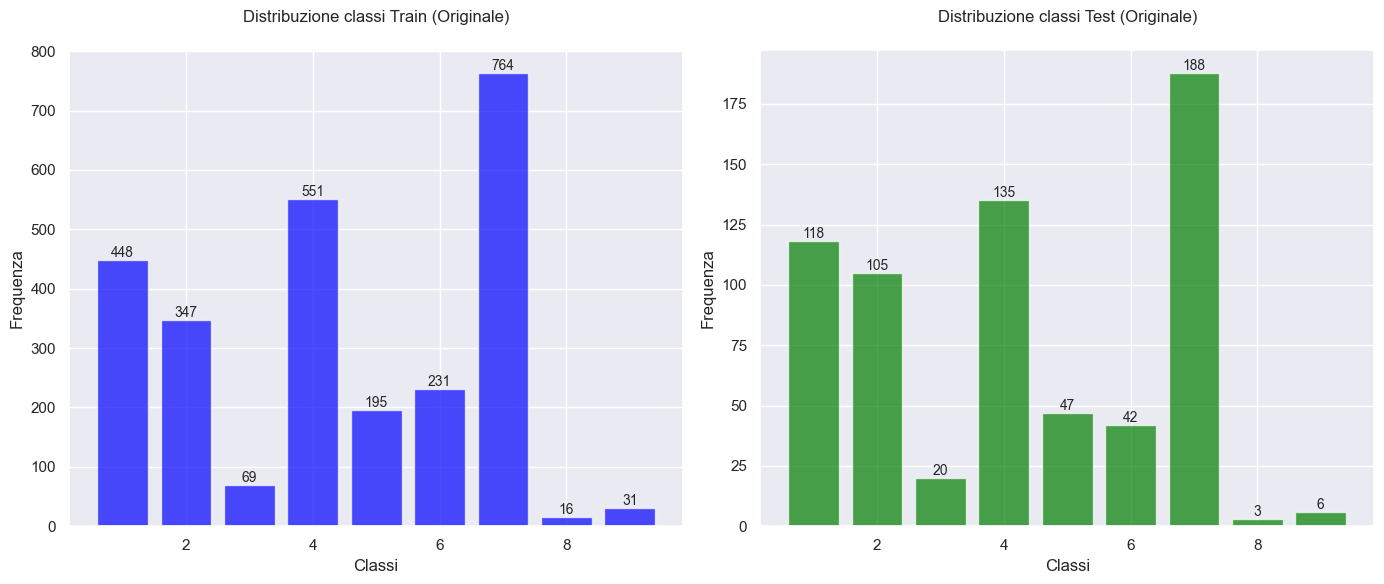

In [16]:
# Dataset originario diviso in (80/20) train e test con TF-IDF e SVD
def process_original_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    tfidf = TfidfVectorizer(max_features=1000)
    svd = TruncatedSVD(n_components=100)
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svd)
    X_test_scaled = scaler.transform(X_test_svd)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Dataset originario diviso in (80/20) train e test con TF-IDF e SVD
X_train_scaled, X_test_scaled, y_train, y_test = process_original_dataset(X, y)

# Generazione dei grafici per la distribuzione delle classi
plot_class_distribution(y_train, y_test, title_train="Distribuzione classi Train (Originale)", title_test="Distribuzione classi Test (Originale)")


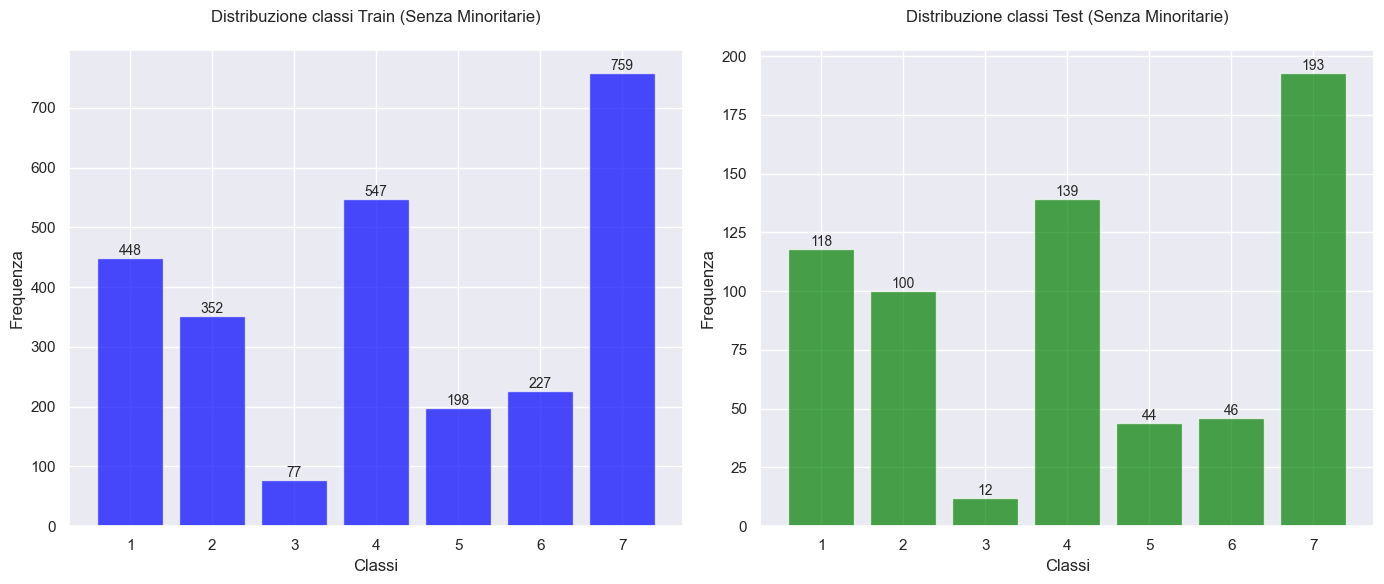

In [17]:
def process_removedclass_dataset(X, y):
    # Rimuove le righe con classi 8 e 9
    mask = ~np.isin(y, [8, 9])  # Crea una maschera per filtrare
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Dividi il dataset filtrato in train e test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
    
    # Applica TF-IDF ai dati di train e test
    tfidf = TfidfVectorizer(max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Applica SVD al dataset
    svd = TruncatedSVD(n_components=100)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    
    # Scala i dati
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svd)
    X_test_scaled = scaler.transform(X_test_svd)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Esempio di utilizzo della funzione
X_train_scaled, X_test_scaled, y_train, y_test = process_removedclass_dataset(X, y)

# (Assicurati di implementare questa funzione o di averla disponibile nel tuo ambiente)
plot_class_distribution(y_train, y_test, title_train="Distribuzione classi Train (Senza Minoritarie)", title_test="Distribuzione classi Test (Senza Minoritarie)")


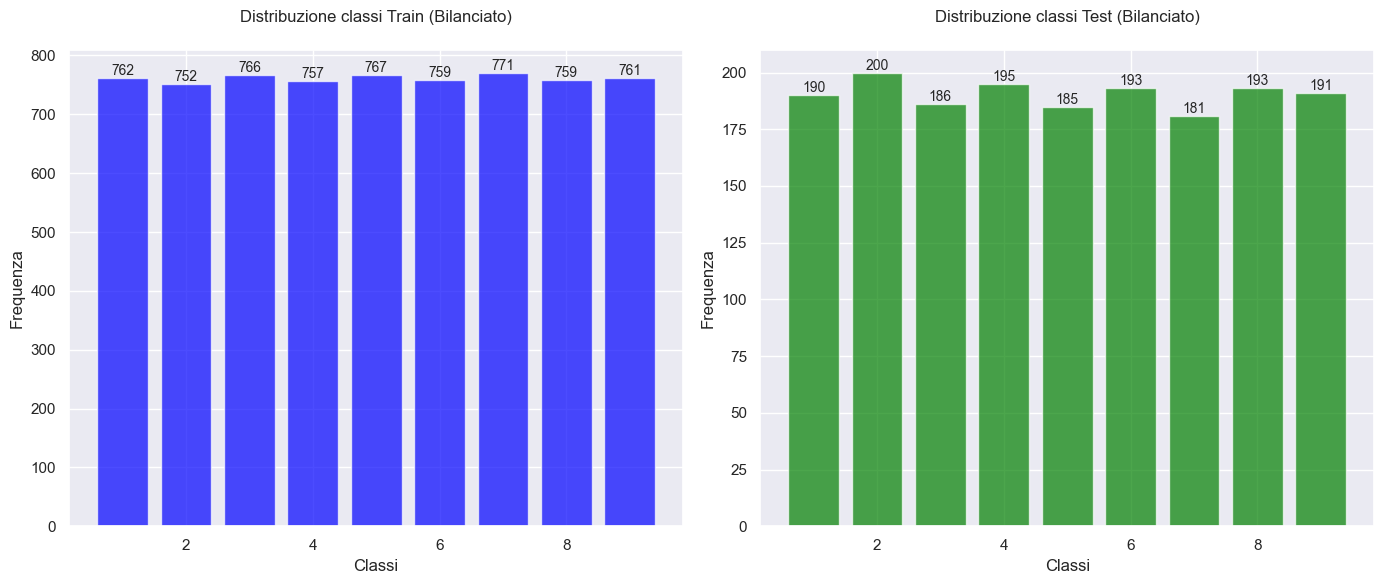

In [19]:
# Dataset bilanciato con RandomOverSampler e poi diviso in (80/20) train, test con TF-IDF e SVD
def process_balanced_dataset(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)
    X_resampled = pd.Series(X_resampled.flatten())
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    tfidf = TfidfVectorizer(max_features=1000)
    svd = TruncatedSVD(n_components=100)
    
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_svd)
    X_test_scaled = scaler.transform(X_test_svd)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Dataset bilanciato con RandomOverSampler
X_train_scaled, X_test_scaled, y_train, y_test = process_balanced_dataset(X, y)

# Generazione dei grafici per la distribuzione delle classi
plot_class_distribution(y_train, y_test, title_train="Distribuzione classi Train (Bilanciato)", title_test="Distribuzione classi Test (Bilanciato)")


In [20]:
# Funzione per addestrare, ottimizzare e testare i modelli su un dataset specifico
def train_evaluate_model(model, model_name, X, y, dataset_type):
    if dataset_type == "original":
        X_train, X_test, y_train, y_test = process_original_dataset(X, y)
    elif dataset_type == "semibalanced":
        X_train, X_test, y_train, y_test = process_removedclass_dataset(X, y)
    elif dataset_type == "balanced":
        X_train, X_test, y_train, y_test = process_balanced_dataset(X, y)
      
    else:
        raise ValueError("Dataset non valido per l'addestramento")
    
    param_grids = get_param_grids()
    
    # Se si utilizza XGBoost, codifica le etichette
    if model_name == "XGBoost":
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)
    
    best_model, best_params = perform_grid_search(model, X_train, y_train, param_grids[model_name])
    precision, recall, f1, accuracy = evaluate_model(best_model, X_test, y_test)
    
    # Arrotonda le metriche a 4 cifre decimali
    precision = round(precision, 4)
    recall = round(recall, 4)
    f1 = round(f1, 4)
    accuracy = round(accuracy, 4)
    
    return [model_name, precision, recall, f1, accuracy]

In [21]:
# Sezione per il modello RandomForest
print("Valutazione su set di Test per RandomForest Classifier")

# Valutazione su dataset originale, bilanciato e semibilanciato
rf_results_original = ["Originale"] + train_evaluate_model(RandomForestClassifier(), "RF", X, y, "original")
rf_results_semibalanced = ["Semibilanciato"] + train_evaluate_model(RandomForestClassifier(), "RF", X, y, "semibalanced")  
rf_results_balanced = ["Bilanciato"] + train_evaluate_model(RandomForestClassifier(), "RF", X, y, "balanced")

# Raggruppamento dei risultati
rf_results = [rf_results_original, rf_results_semibalanced, rf_results_balanced]

# Intestazioni della tabella
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

# Stampa della tabella con i risultati
print(tabulate(rf_results, headers=headers, tablefmt="grid"))

Valutazione su set di Test per RandomForest Classifier
+----------------+---------+-------------+----------+------------+------------+
| Dataset        | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+================+=========+=============+==========+============+============+
| Originale      | RF      |      0.6236 |   0.6235 |     0.6101 |     0.6235 |
+----------------+---------+-------------+----------+------------+------------+
| Semibilanciato | RF      |      0.6646 |   0.6656 |     0.6575 |     0.6656 |
+----------------+---------+-------------+----------+------------+------------+
| Bilanciato     | RF      |      0.8569 |   0.8582 |     0.8565 |     0.8582 |
+----------------+---------+-------------+----------+------------+------------+


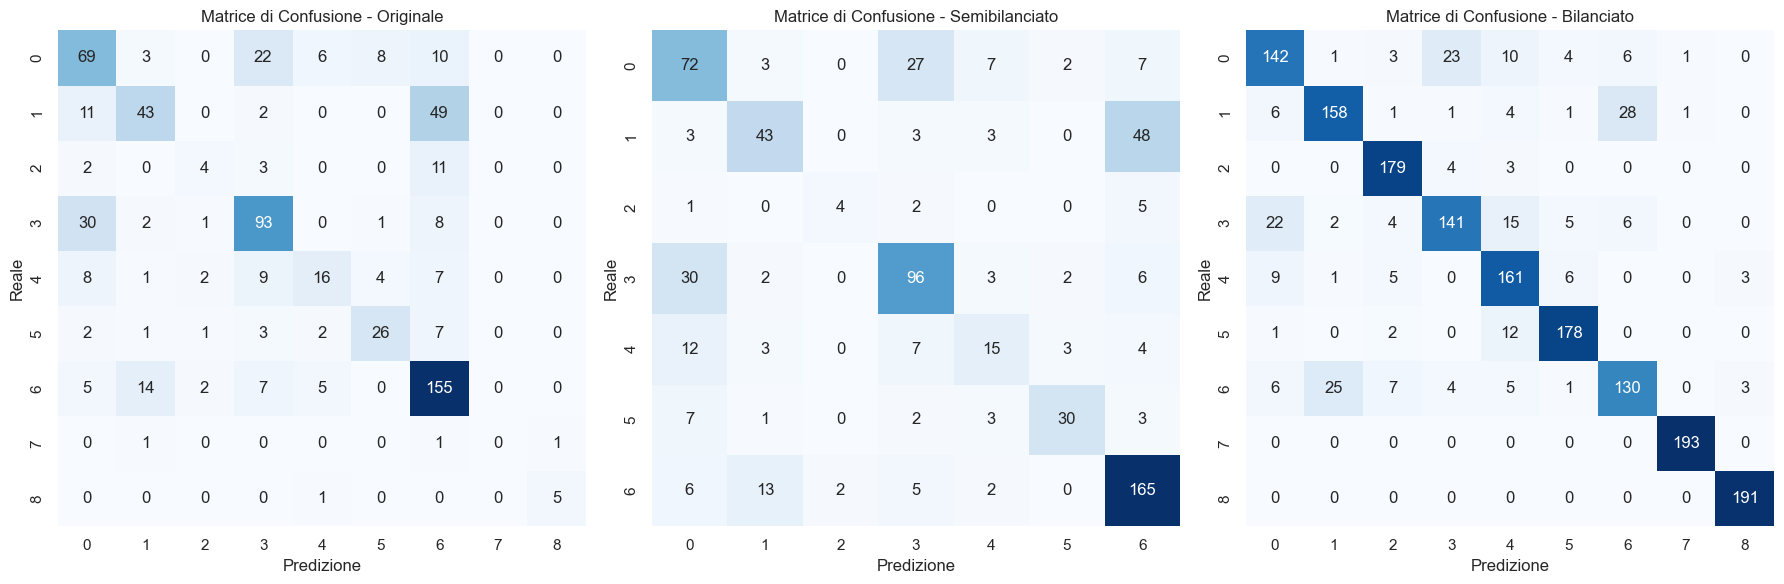

In [22]:

# --- Calcolo delle matrici di confusione ---

# Funzione per ottenere il miglior modello da train_evaluate_model
def get_best_model_and_data(X, y, dataset_type):
    if dataset_type == "original":
        X_train, X_test, y_train, y_test = process_original_dataset(X, y)
    elif dataset_type == "semibalanced":
        X_train, X_test, y_train, y_test = process_removedclass_dataset(X, y)
    elif dataset_type == "balanced":
        X_train, X_test, y_train, y_test = process_balanced_dataset(X, y)
    else:
        raise ValueError("Dataset non valido per l'addestramento")
    
    # Ottieni il miglior modello dalla funzione di grid search
    model = RandomForestClassifier()
    param_grids = get_param_grids()
    best_model, best_params = perform_grid_search(model, X_train, y_train, param_grids["RF"])
    
    return best_model, X_test, y_test

# Ottieni il miglior modello e i dati per ogni dataset
best_model_original_rf, X_test_original, y_test_original = get_best_model_and_data(X, y, "original")
best_model_semibalanced_rf, X_test_semibalanced, y_test_semibalanced = get_best_model_and_data(X, y, "semibalanced")
best_model_balanced_rf, X_test_balanced, y_test_balanced = get_best_model_and_data(X, y, "balanced")

# Fai le previsioni
y_pred_original_rf = best_model_original_rf.predict(X_test_original)
y_pred_semibalanced_rf = best_model_semibalanced_rf.predict(X_test_semibalanced)
y_pred_balanced_rf = best_model_balanced_rf.predict(X_test_balanced)

# Calcola le matrici di confusione
cm_original_rf = confusion_matrix(y_test_original, y_pred_original_rf)
cm_semibalanced_rf = confusion_matrix(y_test_semibalanced, y_pred_semibalanced_rf)
cm_balanced_rf = confusion_matrix(y_test_balanced, y_pred_balanced_rf)

# Imposta il grafico
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Disegna la matrice di confusione per il dataset originale
sns.heatmap(cm_original_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Matrice di Confusione - Originale")
axes[0].set_xlabel("Predizione")
axes[0].set_ylabel("Reale")

# Disegna la matrice di confusione per il dataset semibilanciato
sns.heatmap(cm_semibalanced_rf, annot=True, fmt="d", cmap="Blues", ax=axes[1], cbar=False)
axes[1].set_title("Matrice di Confusione - Semibilanciato")
axes[1].set_xlabel("Predizione")
axes[1].set_ylabel("Reale")

# Disegna la matrice di confusione per il dataset bilanciato
sns.heatmap(cm_balanced_rf, annot=True, fmt="d", cmap="Blues", ax=axes[2], cbar=False)
axes[2].set_title("Matrice di Confusione - Bilanciato")
axes[2].set_xlabel("Predizione")
axes[2].set_ylabel("Reale")

# Mostra il grafico
plt.tight_layout()
plt.show()

In [23]:
# Sezione per il modello KNeighbors
print("\nValutazione su set di Test per KNeighbors Classifier")

# Valutazione su dataset originale, bilanciato e semibilanciato
knn_results_original = ["Originale"] + train_evaluate_model(KNeighborsClassifier(), "KNN", X, y, "original")
knn_results_semibalanced = ["Semibilanciato"] + train_evaluate_model(KNeighborsClassifier(), "KNN", X, y, "semibalanced") 
knn_results_balanced = ["Bilanciato"] + train_evaluate_model(KNeighborsClassifier(), "KNN", X, y, "balanced")

# Raggruppamento dei risultati
knn_results = [knn_results_original, knn_results_semibalanced, knn_results_balanced]

# Intestazioni della tabella
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

# Stampa della tabella con i risultati
print(tabulate(knn_results, headers=headers, tablefmt="grid"))



Valutazione su set di Test per KNeighbors Classifier
+----------------+---------+-------------+----------+------------+------------+
| Dataset        | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+================+=========+=============+==========+============+============+
| Originale      | KNN     |      0.6024 |   0.6099 |     0.5972 |     0.6099 |
+----------------+---------+-------------+----------+------------+------------+
| Semibilanciato | KNN     |      0.6277 |   0.6273 |     0.6245 |     0.6273 |
+----------------+---------+-------------+----------+------------+------------+
| Bilanciato     | KNN     |      0.8369 |   0.839  |     0.8356 |     0.839  |
+----------------+---------+-------------+----------+------------+------------+


In [24]:
# Sezione per il modello LogisticRegression
print("\nValutazione su set di Test per LogisticRegression Classifier")

# Valutazione su dataset originale, bilanciato e semibilanciato
lr_results_original = ["Originale"] + train_evaluate_model(LogisticRegression(max_iter=500), "LR", X, y, "original")
lr_results_semibalanced = ["Semibilanciato"] + train_evaluate_model(LogisticRegression(), "LR", X, y, "semibalanced")
lr_results_balanced = ["Bilanciato"] + train_evaluate_model(LogisticRegression(), "LR", X, y, "balanced")

# Raggruppamento dei risultati
lr_results = [lr_results_original, lr_results_semibalanced, lr_results_balanced]

# Intestazioni della tabella
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

# Stampa della tabella con i risultati
print(tabulate(lr_results, headers=headers, tablefmt="grid"))



Valutazione su set di Test per LogisticRegression Classifier


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+----------------+---------+-------------+----------+------------+------------+
| Dataset        | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+================+=========+=============+==========+============+============+
| Originale      | LR      |      0.5429 |   0.5512 |     0.5382 |     0.5512 |
+----------------+---------+-------------+----------+------------+------------+
| Semibilanciato | LR      |      0.574  |   0.5905 |     0.5781 |     0.5905 |
+----------------+---------+-------------+----------+------------+------------+
| Bilanciato     | LR      |      0.7044 |   0.7106 |     0.706  |     0.7106 |
+----------------+---------+-------------+----------+------------+------------+


In [25]:
# Sezione per il modello XGBoost
print("\nValutazione su set di Test per XGBoost Classifier")

# Valutazione su dataset originale, bilanciato e semibilanciato
xgb_results_original = ["Originale"] + train_evaluate_model(XGBClassifier(), "XGBoost", X, y, "original")
xgb_results_semibalanced = ["Semibilanciato"] + train_evaluate_model(XGBClassifier(), "XGBoost", X, y, "semibalanced") 
xgb_results_balanced = ["Bilanciato"] + train_evaluate_model(XGBClassifier(), "XGBoost", X, y, "balanced")

# Raggruppamento dei risultati
xgb_results = [xgb_results_original, xgb_results_semibalanced, xgb_results_balanced]

# Intestazioni della tabella
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]

# Stampa della tabella con i risultati
print(tabulate(xgb_results, headers=headers, tablefmt="grid"))



Valutazione su set di Test per XGBoost Classifier
+----------------+---------+-------------+----------+------------+------------+
| Dataset        | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+================+=========+=============+==========+============+============+
| Originale      | XGBoost |      0.6291 |   0.6295 |     0.6175 |     0.6295 |
+----------------+---------+-------------+----------+------------+------------+
| Semibilanciato | XGBoost |      0.6696 |   0.6687 |     0.6593 |     0.6687 |
+----------------+---------+-------------+----------+------------+------------+
| Bilanciato     | XGBoost |      0.8536 |   0.8553 |     0.8537 |     0.8553 |
+----------------+---------+-------------+----------+------------+------------+


In [26]:
# Funzione per evidenziare il valore migliore in grassetto
def bold_best_f1(results, metric_index):
    # Filtrare solo i valori numerici per evitare problemi di confronto con stringhe
    numeric_results = [row[metric_index] for row in results if isinstance(row[metric_index], (int, float))]
    
    # Identificare il miglior valore di F1
    best_value = max(numeric_results)
    
    # Evidenziare in grassetto il miglior valore di F1
    for i in range(len(results)):
        if isinstance(results[i][metric_index], (int, float)) and results[i][metric_index] == best_value:
            results[i][metric_index] = f"\033[1m{best_value}\033[0m"
    
    return results

# Lista dei risultati per il dataset non bilanciato
original_results = [
    rf_results_original,
    knn_results_original,
    lr_results_original,
    xgb_results_original
]

# Lista dei risultati per il dataset bilanciato
balanced_results = [
    rf_results_balanced,
    knn_results_balanced,
    lr_results_balanced,
    xgb_results_balanced
]

# Lista dei risultati per il dataset semibilanciato
semibalanced_results = [
    rf_results_semibalanced,
    knn_results_semibalanced,
    lr_results_semibalanced,
    xgb_results_semibalanced
]

# Evidenzia il miglior F1-Score per il dataset non bilanciato
original_results = bold_best_f1(original_results, 4)  # Modificato l'indice a 4 per F1-score

# Evidenzia il miglior F1-Score per il dataset bilanciato
balanced_results = bold_best_f1(balanced_results, 4)  # Modificato l'indice a 4 per F1-score

# Evidenzia il miglior F1-Score per il dataset semibilanciato
semibalanced_results = bold_best_f1(semibalanced_results, 4)  # Modificato l'indice a 4 per F1-score

# Stampa la tabella per il dataset non bilanciato
print("\nValutazioni su Dataset Non Bilanciato")
headers = ["Dataset", "Model", "Precision", "Recall", "F1 Score", "Accuracy"]
print(tabulate(original_results, headers=headers, tablefmt="grid"))

# Stampa la tabella per il dataset semibilanciato
print("\nValutazioni su Dataset Semibilanciato")
print(tabulate(semibalanced_results, headers=headers, tablefmt="grid"))

# Stampa la tabella per il dataset bilanciato
print("\nValutazioni su Dataset Bilanciato")
print(tabulate(balanced_results, headers=headers, tablefmt="grid"))




Valutazioni su Dataset Non Bilanciato
+-----------+---------+-------------+----------+------------+------------+
| Dataset   | Model   |   Precision |   Recall |   F1 Score |   Accuracy |
+===========+=========+=============+==========+============+============+
| Originale | RF      |      0.6236 |   0.6235 |     0.6101 |     0.6235 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | KNN     |      0.6024 |   0.6099 |     0.5972 |     0.6099 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | LR      |      0.5429 |   0.5512 |     0.5382 |     0.5512 |
+-----------+---------+-------------+----------+------------+------------+
| Originale | XGBoost |      0.6291 |   0.6295 |     0.6175 |     0.6295 |
+-----------+---------+-------------+----------+------------+------------+

Valutazioni su Dataset Semibilanciato
+----------------+---------+-------------+----------+------------+------------+
| Dataset        